# シュレッダー復元問題の定式化

## ネットワーク定式化

### 定数とインデックス

- $R$: 縦方向の分割数
- $C$: 横方向の分割数
- $N$: 紙片の総数, $R \times C$
- $S^{x}_{ab}$: 紙片 $a$ の右に紙片 $b$ が置かれている場合の類似度
- $S^{y}_{ab}$: 紙片 $a$ の下に紙片 $b$ が置かれている場合の類似度
- $a,b \in [1,\dots,N]$: 紙片を表すインデックス

### 変数

- $x_{ab}$: 紙片 $a$ の右に紙片 $b$ が置かれている場合は $1$ となるフラグ
- $y_{ab}$: 紙片 $a$ の下に紙片 $b$ が置かれている場合は $1$ となるフラグ
- $u^{x}_{a}$: 横方向のポテンシャル
- $u^{y}_{a}$: 縦方向のポテンシャル

### 目的関数

$$
\max \sum_{ab}S^{x}_{ab}x_{ab} + \sum_{ab}S^{y}_{ab}x_{ab}
$$

### 制約条件

- $\sum_{b} x_{ab} = 1$
- $\sum_{b} x_{ba} = 1$
- $\sum_{b} y_{ab} = 1$
- $\sum_{b} y_{ba} = 1$
- $u^{x}_{a} + 1 - (N-1)(1 - x_{ab}) \leq u^{x}_{b}$
- $u^{y}_{a} + 1 - (N-1)(1 - y_{ab}) \leq u^{y}_{b}$
- $u^{x}_{a} - (N-1)(1 - y_{ab}) \leq u^{x}_{b}$
- $u^{y}_{a} - (N-1)(1 - x_{ab}) \leq u^{y}_{b}$



In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pulp
import time

In [2]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)


def imshow(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

In [3]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return (left[:shape[0], -1] == right[:shape[0], 0]).sum()

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return (up[-1, :shape[1]] == down[0, :shape[1]]).sum()

In [4]:
def build_model(data):
    model = pulp.LpProblem(sense=pulp.LpMaximize)
    x = np.array(pulp.LpVariable.matrix(
        'x',
        (range(data.size + 1), range(data.size + 1)),
        cat=pulp.LpBinary
    ))
    y = np.array(pulp.LpVariable.matrix(
        'y',
        (range(data.size + 1), range(data.size + 1)),
        cat=pulp.LpBinary
    ))
    ux = np.array(pulp.LpVariable.matrix(
        'ux',
        (range(data.size),),
        lowBound=1.0,
        upBound=data.cols,
        cat=pulp.LpContinuous
    ))
    uy = np.array(pulp.LpVariable.matrix(
        'uy',
        (range(data.size),),
        lowBound=1.0,
        upBound=data.rows,
        cat=pulp.LpContinuous
    ))
    for a in range(data.size + 1):
        x[a, a].upBound = 0
        x[a, a].lowBound = 0
        y[a, a].upBound = 0
        y[a, a].lowBound = 0

    model.setObjective(pulp.lpSum(
            sim_x(data.images[a], data.images[b])*x[a, b]
            for a in range(data.size)
            for b in range(data.size)
            if a != b
        ) + pulp.lpSum(
            sim_y(data.images[a], data.images[b])*y[a, b]
            for a in range(data.size)
            for b in range(data.size)
            if a != b
        )
    )

    for a in range(data.size):
        model.addConstraint(pulp.lpSum(x[a]) == 1)
        model.addConstraint(pulp.lpSum(x[:, a]) == 1)
        model.addConstraint(pulp.lpSum(y[a]) == 1)
        model.addConstraint(pulp.lpSum(y[:, a]) == 1)
    model.addConstraint(pulp.lpSum(x[-1]) == data.rows)
    model.addConstraint(pulp.lpSum(x[:-1, -1]) == data.rows)
    model.addConstraint(pulp.lpSum(y[-1]) == data.cols)
    model.addConstraint(pulp.lpSum(y[:, -1]) == data.cols)


    for a in range(data.size):
        for b in range(data.size):
            if a != b:
                model.addConstraint(
                    ux[a] + 1 - data.cols*(1 - x[a, b]) <= ux[b]
                )
                model.addConstraint(
                    ux[a] - data.cols*(1 - y[a, b] - y[b, a]) <= ux[b]
                )
                model.addConstraint(
                    uy[a] + 1 - data.rows*(1 - y[a, b]) <= uy[b]
                )
                model.addConstraint(
                    uy[a] - data.rows*(1 - x[a, b] - x[b, a]) <= uy[b]
                )
                model.addConstraint(
                    x[a, b] + x[b, a] <= 1
                )
                model.addConstraint(
                    y[a, b] + y[b, a] <= 1
                )
                model.addConstraint(
                    x[a, b] + y[a, b] <= 1
                )
                model.addConstraint(
                    x[a, b] + y[b, a] <= 1
                )
    return model, x, y, ux, uy

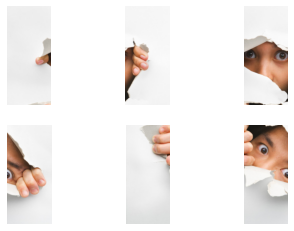

In [5]:
DATA_PATHS = [
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_3.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_5.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_5.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_10.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_10.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_30.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_30.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_50.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_50.pkl',
]

data = load_data(DATA_PATHS[0])
imshow(data.images, data.rows, data.cols)

In [6]:
def show_solution(data, ux, uy):
    imshow(
        [data.images[a] for a in sorted(range(data.size), key=lambda x: uy[x].value()*data.cols + ux[x].value())],
        data.rows,
        data.cols
    )

--- data: rows=2, cols=3 ---
	elapsed_time(s)=0.015795230865478516
	cost=2080.0
	state=Optimal


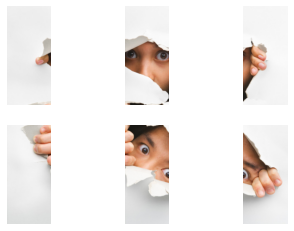

--- data: rows=2, cols=5 ---
	elapsed_time(s)=0.035790443420410156
	cost=3070.0
	state=Optimal


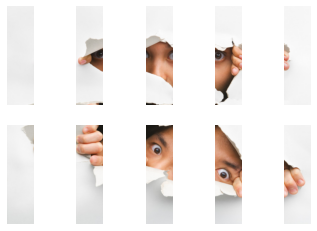

--- data: rows=4, cols=5 ---
	elapsed_time(s)=0.1067502498626709
	cost=4126.0
	state=Optimal


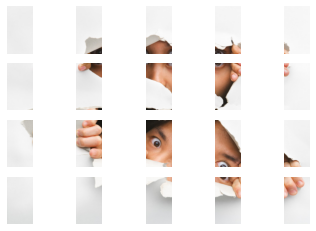

--- data: rows=2, cols=10 ---
	elapsed_time(s)=0.10872125625610352
	cost=6340.0
	state=Optimal


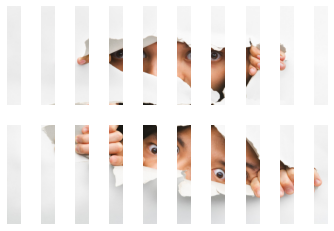

--- data: rows=4, cols=10 ---
	elapsed_time(s)=0.5070993900299072
	cost=7396.0
	state=Optimal


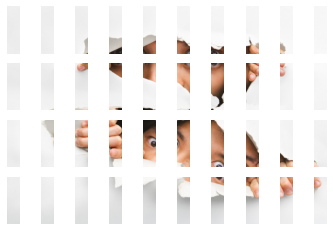

--- data: rows=2, cols=30 ---
	elapsed_time(s)=2.4375107288360596
	cost=27213.0
	state=Optimal


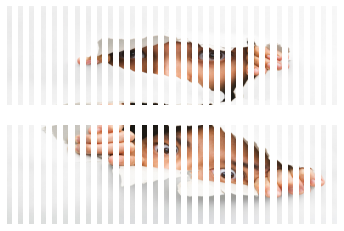

--- data: rows=4, cols=30 ---
	elapsed_time(s)=34.76541829109192
	cost=28269.0
	state=Optimal


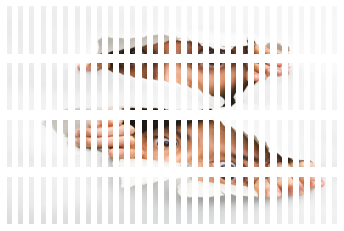

--- data: rows=2, cols=50 ---
	elapsed_time(s)=36.83682680130005
	cost=33692.0
	state=Optimal


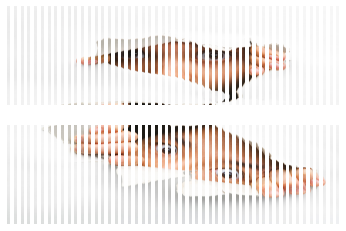

KeyboardInterrupt: 

In [7]:
solver = pulp.GUROBI_CMD(timeLimit=30*60)

for data_path in DATA_PATHS:
    data = load_data(data_path)
    model, x, y, ux, uy = build_model(data)
    start = time.time()
    status = solver.solve(model)
    elapsed_time = time.time() - start

    print(f'--- data: rows={data.rows}, cols={data.cols} ---')
    print(f'\telapsed_time(s)={elapsed_time}')
    print(f'\tcost={model.objective.value()}')
    print(f'\tstate={pulp.LpStatus[status]}')

    show_solution(data, ux, uy)
    plt.show()

    if elapsed_time > 30*60:
        break